In [1]:
# %% [markdown]
"""
# Notebook de Clustering de Tickets Jira
**16 000 tickets | i5/16Go RAM | Évaluation Complète**
"""
# %%
# %% [markdown]

'\n# Notebook de Clustering de Tickets Jira\n**16 000 tickets | i5/16Go RAM | Évaluation Complète**\n'

In [4]:
"""
## 1. Configuration Initiale
**Objectif** : Optimiser l'utilisation mémoire et préparer l'environnement
"""

"\n## 1. Configuration Initiale\n**Objectif** : Optimiser l'utilisation mémoire et préparer l'environnement\n"

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from hdbscan import HDBSCAN, validity_index
from sentence_transformers import SentenceTransformer
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from keybert import KeyBERT
from tqdm.auto import tqdm
import gc

In [7]:
# %%
# %% [markdown]
"""
## 2. Chargement des Données
**Stratégie** : Chargement séquentiel avec types optimisés
"""
# %%

'\n## 2. Chargement des Données\n**Stratégie** : Chargement séquentiel avec types optimisés\n'

In [8]:
def load_data(path):
    """Charge les données avec gestion mémoire"""
    dtypes = {'Summary': 'category', 'Description': 'category'}
    
    with tqdm(total=1, desc="Chargement données") as pbar:
        df = pd.read_csv(path, usecols=['Summary'], dtype=dtypes)
        df['Summary'] = df['Summary'].astype('string')  # Meilleur pour NLP
        pbar.update(1)
    
    return df

In [9]:
# %%
# %% [markdown]
"""
## 3. Génération d'Embeddings
**Choix du modèle** : `paraphrase-multilingual-MiniLM-L12-v2`  
**Pourquoi** :  
- Gère mix FR/EN sans traduction  
- Léger (420MB) mais performant  
- 384 dimensions (équilibre performance/mémoire)
"""
# %%

"\n## 3. Génération d'Embeddings\n**Choix du modèle** : `paraphrase-multilingual-MiniLM-L12-v2`  \n**Pourquoi** :  \n- Gère mix FR/EN sans traduction  \n- Léger (420MB) mais performant  \n- 384 dimensions (équilibre performance/mémoire)\n"

In [ ]:
def generate_embeddings(texts):
    """Génère des embeddings par lots avec libération mémoire"""
    model = SentenceTransformer(
        'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2',
        device='cpu',
        cache_folder='./cache'
    )
    
    embeddings = []
    for i in tqdm(range(0, len(texts), BATCH_SIZE), desc="Embedding"):
        batch = texts[i:i+BATCH_SIZE]
        embeddings.append(model.encode(
            batch,
            show_progress_bar=False,
            convert_to_numpy=True,
            normalize_embeddings=True,
            batch_size=32
        ))
        gc.collect()  # Libération mémoire explicite
    
    return np.vstack(embeddings)

In [11]:
# %%
# %% [markdown]
"""
## 4. Clustering et Réduction Dimensionnelle
**Paramétrage HDBSCAN** :  
- `min_cluster_size=25` : Évite les micro-clusters  
- `cluster_selection_epsilon=0.1` : Fusion automatique  
- `memory='./cache'` : Réutilisation des calculs
"""
# %%

"\n## 4. Clustering et Réduction Dimensionnelle\n**Paramétrage HDBSCAN** :  \n- `min_cluster_size=25` : Évite les micro-clusters  \n- `cluster_selection_epsilon=0.1` : Fusion automatique  \n- `memory='./cache'` : Réutilisation des calculs\n"

In [12]:
def cluster_data(embeddings):
    """Pipeline complet de clustering"""
    # Réduction dimensionnelle
    with tqdm(total=1, desc="UMAP") as pbar:
        reducer = UMAP(
            n_components=N_COMPONENTS,
            n_neighbors=15,
            metric='cosine',
            low_memory=True
        )
        reduced_embeds = reducer.fit_transform(embeddings)
        pbar.update(1)
    
    # Clustering
    with tqdm(total=1, desc="HDBSCAN") as pbar:
        clusterer = HDBSCAN(
            min_cluster_size=max(25, int(len(embeddings)*0.0005)),
            min_samples=3,
            cluster_selection_epsilon=0.1,
            memory='./cache'
        )
        clusters = clusterer.fit_predict(reduced_embeds)
        pbar.update(1)
    
    return clusters, reduced_embeds


In [13]:
# %%
# %% [markdown]
"""
## 5. Évaluation des Clusters
**Métriques choisies** :  
1. **DBCV** (Density-Based Cluster Validity) : Spécifique aux méthodes densité  
2. **Silhouette Score** : Mesure standard de cohérence  
3. **Calinski-Harabasz** : Ratio dispersion intra/inter clusters  

**Pourquoi ces métriques** :  
- Complémentaires pour clusters de densité variable  
- Robustes au bruit (cluster -1)  
- Interprétabilité des résultats
"""
# %%

'\n## 5. Évaluation des Clusters\n**Métriques choisies** :  \n1. **DBCV** (Density-Based Cluster Validity) : Spécifique aux méthodes densité  \n2. **Silhouette Score** : Mesure standard de cohérence  \n3. **Calinski-Harabasz** : Ratio dispersion intra/inter clusters  \n\n**Pourquoi ces métriques** :  \n- Complémentaires pour clusters de densité variable  \n- Robustes au bruit (cluster -1)  \n- Interprétabilité des résultats\n'

In [30]:
def evaluate_clusters(embeddings, clusters, reduced_embeds):
    """Calcule les métriques clés avec gestion des erreurs"""
    metrics = {}
    
    # 1. Conversion des types pour HDBSCAN
    embeddings_float64 = np.array(embeddings, dtype=np.float64)
    clusters_int = clusters.astype(np.int32)
    
    # 2. DBCV Score (avec gestion d'erreur)
    try:
        metrics['DBCV'] = validity_index(embeddings_float64, clusters_int)
    except Exception as e:
        print(f"⚠ Erreur DBCV: {str(e)}")
        metrics['DBCV'] = None
    
    # 3. Silhouette Score (échantillonnage pour grandes datasets)
    sample_size = min(2000, len(embeddings))
    sample_idx = np.random.choice(len(embeddings), sample_size, replace=False)
    
    try:
        metrics['Silhouette'] = silhouette_score(
            reduced_embeds[sample_idx], 
            clusters[sample_idx]
        )
    except Exception as e:
        print(f"⚠ Erreur Silhouette: {str(e)}")
        metrics['Silhouette'] = None
    
    # 4. Nombre de clusters et bruit
    metrics['Clusters Identifiés'] = len(set(clusters)) - (1 if -1 in clusters else 0)
    metrics['Points de Bruit (%)'] = np.mean(clusters == -1) * 100
    
    return metrics

In [15]:
# %%
# %% [markdown]
"""
## 6. Visualisation et Analyse
**Objectif** : Comprendre la structure des clusters et valider la qualité
"""
# %%

'\n## 6. Visualisation et Analyse\n**Objectif** : Comprendre la structure des clusters et valider la qualité\n'

In [16]:
def visualize_results(clusters, reduced_embeds, df):
    """Affiche les visualisations clés"""
    # Configuration des plots
    plt.figure(figsize=(15, 10))
    
    # 1. Distribution des clusters
    plt.subplot(221)
    pd.Series(clusters).value_counts().plot(kind='bar', logy=True)
    plt.title('Distribution des Tailles de Clusters (échelle log)')
    
    # 2. Projection UMAP
    plt.subplot(222)
    plt.scatter(
        reduced_embeds[:, 0], 
        reduced_embeds[:, 1], 
        c=clusters, 
        cmap='Spectral',
        s=5,
        alpha=0.5
    )
    plt.title('Projection 2D des Clusters')
    
    # 3. Exemples par cluster
    plt.subplot(212)
    plt.axis('off')
    sample_text = "\n".join([
        f"Cluster {c} : {df[df['Cluster']==c]['Summary'].iloc[0][:50]}..."
        for c in np.unique(clusters) if c != -1
    ])
    plt.text(0, 0.5, sample_text, fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()

In [17]:
# %%
# %% [markdown]
"""
## 7. Pipeline Complet
"""
# %%
# Chargement des données

'\n## 7. Pipeline Complet\n'

In [22]:
import os

# Configuration globale
BATCH_SIZE = 200  # Optimisé pour 16Go RAM
N_COMPONENTS = 10  # Dimension pour UMAP
MIN_CLUSTER_SIZE = 25  # Taille minimale des clusters
os.makedirs('./cache', exist_ok=True)  # Dossier pour les caches

In [23]:
# Chargement des données

df = load_data('C:/Users/my.kassem/Desktop/exploratory data analysis/df_filtre_status_type_description_resolution_copy.csv')


Chargement données:   0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
# Génération des embeddings
embeddings = generate_embeddings(df['Summary'].tolist())

Embedding:   0%|          | 0/80 [00:00<?, ?it/s]

In [31]:
embeddings = np.array(embeddings, dtype=np.float64)  # Conversion explicite


In [32]:
# Clustering
clusters, reduced_embeds = cluster_data(embeddings)
df['Cluster'] = clusters


UMAP:   0%|          | 0/1 [00:00<?, ?it/s]

HDBSCAN:   0%|          | 0/1 [00:00<?, ?it/s]

In [33]:
# Évaluation
metrics = evaluate_clusters(embeddings, clusters, reduced_embeds)
print("\n📊 Métriques d'Évaluation :")
for k, v in metrics.items():
    print(f"- {k}: {v if not isinstance(v, float) else f'{v:.2f}'}")

c:\Users\my.kassem\Desktop\Intelligent_analysis_of_JIRA_tickets\.venv\lib\site-packages\hdbscan\validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[
c:\Users\my.kassem\Desktop\Intelligent_analysis_of_JIRA_tickets\.venv\lib\site-packages\hdbscan\validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[
c:\Users\my.kassem\Desktop\Intelligent_analysis_of_JIRA_tickets\.venv\lib\site-packages\hdbscan\validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[
c:\Users\my.kassem\Desktop\Intelligent_analysis_of_JIRA_tickets\.venv\lib\site-packages\hdbscan\validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[
c:\Users\my.kassem\Desktop\Intelligent_analysis_of_JIRA_tickets\.venv\lib\site-packages\hdbscan\validity


📊 Métriques d'Évaluation :
- DBCV: -0.15
- Silhouette: 0.12536491453647614
- Clusters Identifiés: 141
- Points de Bruit (%): 33.53


C:\Users\my.kassem\AppData\Local\Temp\ipykernel_24048\1731838554.py:32: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


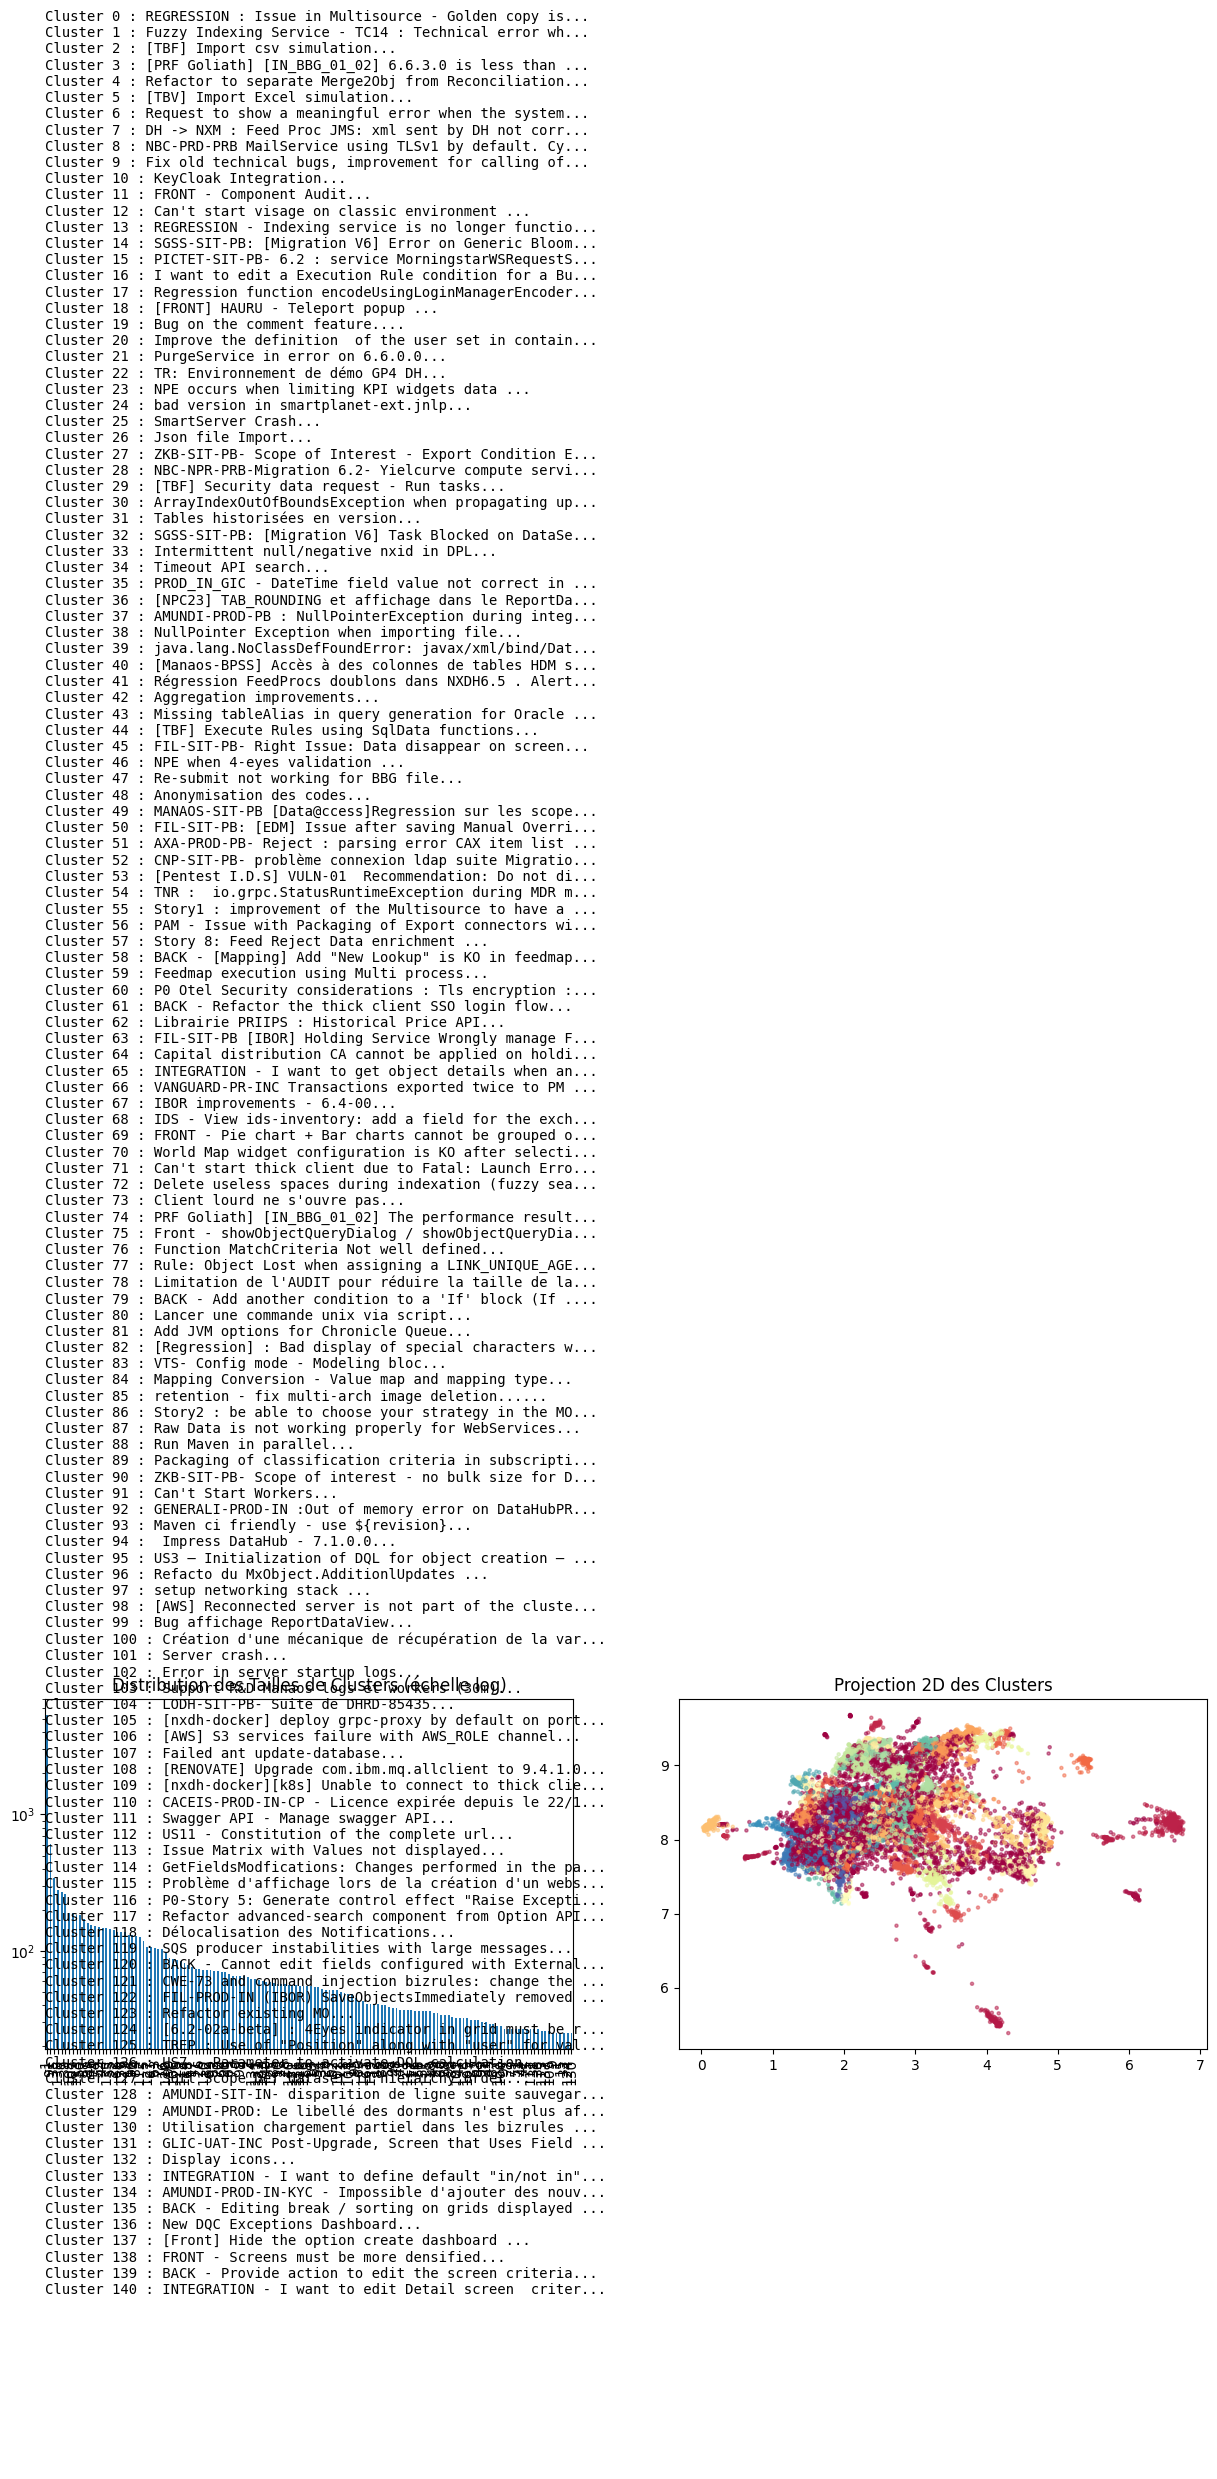

In [35]:
# Visualisation
visualize_results(clusters, reduced_embeds, df)

In [36]:
# Extraction des topics
kw_model = KeyBERT()
topics = {}
for cl_id in tqdm(set(clusters) - {-1}, desc="Extraction des topics"):
    cluster_texts = df[df['Cluster'] == cl_id]['Summary'].tolist()
    keywords = kw_model.extract_keywords(
        " ".join(cluster_texts),
        keyphrase_ngram_range=(1, 2),
        stop_words=None,
        top_n=3
    )
    topics[cl_id] = ", ".join([kw[0] for kw in keywords])

Extraction des topics:   0%|          | 0/141 [00:00<?, ?it/s]

In [29]:
# Sauvegarde
df.to_csv('jira_clustered.csv', index=False)
print("\n✅ Résultats sauvegardés dans jira_clustered.csv")


✅ Résultats sauvegardés dans jira_clustered.csv


pour la premiere execution on a tester 
        reducer = UMAP(
            n_components=N_COMPONENTS,
            n_neighbors=15,
            metric='cosine',
            low_memory=True
        )
et pour le clustering nous avons opté a ces hyperparametres:
    # Clustering
    with tqdm(total=1, desc="HDBSCAN") as pbar:
        clusterer = HDBSCAN(
            min_cluster_size=max(25, int(len(embeddings)*0.0005)),
            min_samples=3,
            cluster_selection_epsilon=0.1,
            memory='./cache'
        )
pour la configuration on a faire ca:
# Configuration globale
BATCH_SIZE = 200  # Optimisé pour 16Go RAM
N_COMPONENTS = 10  # Dimension pour UMAP
MIN_CLUSTER_SIZE = 25  # Taille minimale des clusters
os.makedirs('./cache', exist_ok=True)  # Dossier pour les caches

nous avons obtenu comme evaluation :
📊 Métriques d'Évaluation :
- DBCV: -0.15
- Silhouette: 0.12536491453647614
- Clusters Identifiés: 141
- Points de Bruit (%): 33.53

In [40]:
import pandas as pd

# Création d'un rapport de validation
cluster_report = []

for cl_id in set(df['Cluster']) - {-1}:
    cluster_df = df[df['Cluster'] == cl_id]
    
    # Échantillonnage de quelques summaries
    sample_summaries = cluster_df['Summary'].sample(min(5, len(cluster_df)), random_state=42).tolist()
    
    cluster_report.append({
        'Cluster': cl_id,
        'Nb_tickets': len(cluster_df),
        'Topic': topics.get(cl_id, 'Aucun topic'),
        'Exemples_summaries': "\n- " + "\n- ".join(sample_summaries)
    })

# Création du DataFrame et tri par taille de cluster
report_df = pd.DataFrame(cluster_report).sort_values('Nb_tickets', ascending=True)

# Affichage formaté
for _, row in report_df.iterrows():
    print(f"Cluster {row['Cluster']}")
    print(f"Nombre de tickets: {row['Nb_tickets']}")
    print(f"Topic: {row['Topic']}")
    print(f"Exemples de summaries:{row['Exemples_summaries']}")
    print("\n" + "-"*80 + "\n")

Cluster 33
Nombre de tickets: 25
Topic: nulle dqc, dqc null, valeur null
Exemples de summaries:
- Umbrella share status à 0 / Problème de prod
- Erreur sur un custom control lorsque la donnée est nulle
- Intermittent null/negative nxid in DPL
- Even Null function not working
- Null dans un champ de type numérique

--------------------------------------------------------------------------------

Cluster 1
Nombre de tickets: 25
Topic: search fuzzy, fuzzysearch non, tronqué fuzzysearch
Exemples de summaries:
- Fuzzy Indexing Service - TC1 - Special characters not returning entity in first hit with fuzzy search
- User action: Implementation of Fuzzy Search
- Fuzzy Indexing Service - TC14 : Technical error when name contains "AND" and ")" character
- Fuzzy matching - recherche incomplet, le résultat paraît tronqué
- FuzzySearch check indexqueryservice is available or enable  

--------------------------------------------------------------------------------

Cluster 124
Nombre de tickets: 25

In [43]:
# Récupération des outliers
outliers = df[df['Cluster'] == -1]

# Statistiques de base
print(f"Nombre total d'outliers: {len(outliers)}")
print(f"Pourcentage d'outliers: {len(outliers)/len(df)*100:.2f}%")

# Échantillon d'outliers pour inspection
outlier_samples = outliers['Summary'].sample(min(10, len(outliers)), random_state=42).tolist()
print("\nExemples d'outliers:")
print("- " + "\n- ".join(outlier_samples))

Nombre total d'outliers: 5359
Pourcentage d'outliers: 33.53%

Exemples d'outliers:
- Impossible de supprimer des blocs if dans les rules
- ADEV34 - A37 quote référence
- GLIC - Issue with Webclient login using custom login manager
- The user of modification is not available in "Show Object History"
- Format condition doesn't evaluate rec spec correctly
- AMUNDI-PROD-PB KYC - Problème de rafraichissement après sauvegarde de dossier
- [Manaos-BPSS] Incohérence affichage Visage critères sur écran
- [support] Service Multifileexport.
- Bookmarks : I want to remove screens from Favorites
- Client léger - Tracker - création d'objets ne raffraichit pas l'écran


In [48]:
# Création d'un rapport complet
output_df = df.copy()
output_df['Topic'] = output_df['Cluster'].map(topics)

# Pour chaque cluster, ajout du nombre de tickets dans le cluster
cluster_sizes = output_df['Cluster'].value_counts().to_dict()
output_df['Cluster_size'] = output_df['Cluster'].map(cluster_sizes)

# Tri et sélection des colonnes
final_export = output_df.sort_values(['Cluster', 'Summary'])[
    ['Cluster', 'Cluster_size', 'Topic', 'Summary']  # Ajoutez d'autres colonnes au besoin
]

# Export
final_export.to_csv('detailed_clusters_verification.csv', index=False, encoding='utf-8-sig')